<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Building-&amp;-training-the-model" data-toc-modified-id="Building-&amp;-training-the-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building &amp; training the model</a></span></li><li><span><a href="#Looking-at-individual-results" data-toc-modified-id="Looking-at-individual-results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Looking at individual results</a></span></li></ul></div>

# Building & training the model

In [ ]:
import torch
torch.cuda.is_available()

False

epoch,train_loss,valid_loss,time
0,3.453580,0.768220,00:11
1,2.207201,0.397464,00:11
2,1.148770,0.204741,00:11
3,0.548770,0.127273,00:11
4,0.283803,0.099545,00:11
5,0.178413,0.092499,00:11
6,0.137944,0.088526,00:11
7,0.118475,0.085256,00:11
8,0.111273,0.084411,00:11
9,0.107832,0.083322,00:11


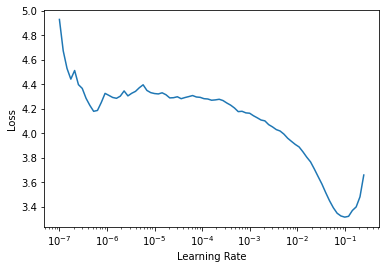

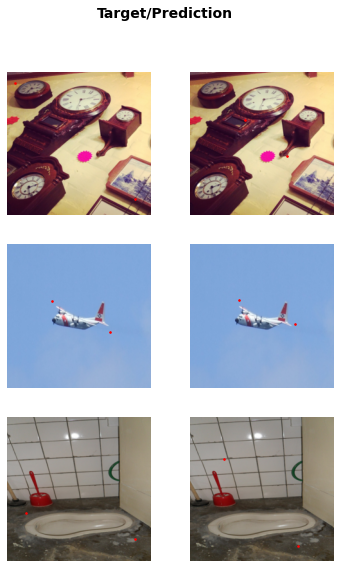

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
train_json   = 'annotations/instances_train2017.json'
valid_json   = 'annotations/instances_val2017.json'
train_im_dir = 'train2017'
valid_im_dir = 'val2017'


### Get files and annos ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
files  = train_files + valid_files
annos  = train_annos + valid_annos
bboxes = [a[0] for a in annos]
lbls   = [a[1] for a in annos]


### Get largest anno ###
def transpose(anno): return list(zip(*anno)) # tensor.t()
def bbox_area(transposed_anno):
    b = transposed_anno[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = L(sort_annos(i) for i in annos)
largest_anno = L(i[0] for i in sorted_annos)
largest_bbox = L(i[0] for i in largest_anno)
largest_lbl  = L(i[1] for i in largest_anno)
# get_xyz helpers (used in following sections)
files2lbl  = {f:l for f,l in zip(files,largest_lbl)}
files2bbox = {f:b for f,b in zip(files,largest_bbox)}
def get_lbl(f):  return files2lbl[f]
def get_bbox(f): return files2bbox[f]


### Get singles ###
# identify singles
lbls_per_im = L(len(l) for l in lbls)
tuples = L(zip(files, largest_lbl, largest_bbox))
singles = tuples[lbls_per_im.map(lambda n:n==1)]
singles_tp = transpose(singles)
# identify lbls with at least 500 singles
lbl2paths = {l:[p for p in singles_tp[0] if get_lbl(p) == l] 
             for l in set(singles_tp[1])}
lbl_subset=[]
for lbl in lbl2paths:
    l = len(lbl2paths[lbl])
    if l > 500: lbl_subset += [lbl]
# create subset of ims in lbl_subset
subset = L(s for s in singles if s[1] in lbl_subset)
files_subset = L(i[0] for i in subset)


### Datasets & DataLoaders ###
# dss
dss_tfms = [[PILImage.create], [get_bbox, TensorPointCreate]]
splits = RandomSplitter(.15)(files_subset)
dss = Datasets(files_subset, tfms=dss_tfms, splits=splits)
# dls
cpu_tfms = [PointScaler(), Resize(im_size, method=ResizeMethod.Squish), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize()]
dls = dss.dataloaders(bs=64, after_item=cpu_tfms, after_batch=gpu_tfms)


### Model & Train ###
learn = cnn_learner(dls, resnet34)
lr_min, _ = learn.lr_find()
learn.fit_one_cycle(10, lr=lr_min) # valid_loss of .0786 after 9 epochs (2min 33s)
learn.show_results()

# Looking at individual results

In [ ]:
xb,yb = dls.one_batch()

In [ ]:
yp = learn.model(xb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0515422448515892

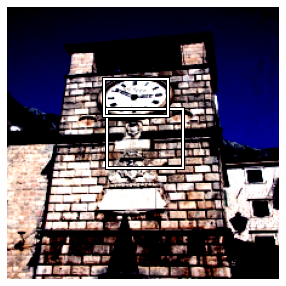

In [ ]:
shape = [64,4]
yb_rs = yb.reshape(shape)
yp_rs = yp.reshape(shape)

i = 0
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)

forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)

ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.004737015347927809

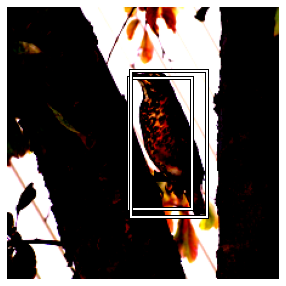

In [ ]:
i = 1
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.16011619567871094

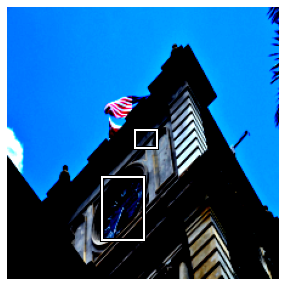

In [ ]:
i = 2
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.02973165176808834

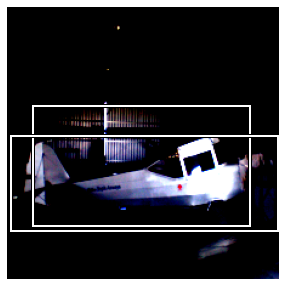

In [ ]:
i = 3
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.30498531460762024

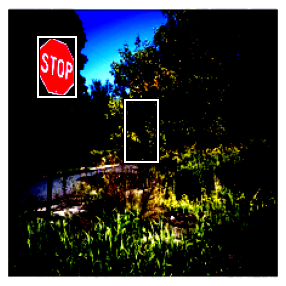

In [ ]:
i = 4
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05798999220132828

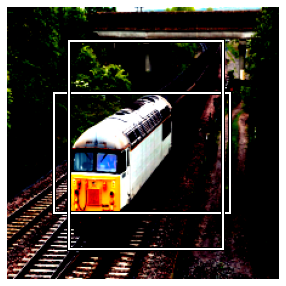

In [ ]:
i = 5
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.07480265945196152

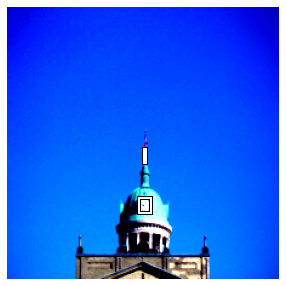

In [ ]:
i = 6
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.16626468300819397

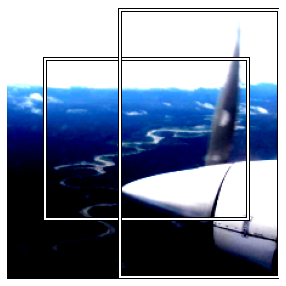

In [ ]:
i = 7
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05661565810441971

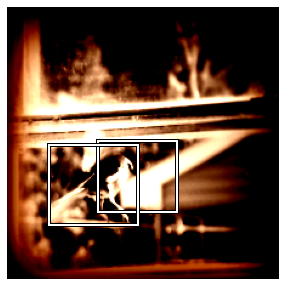

In [ ]:
i = 8
im       = xb[i]
forecast = yp_rs[i]
actual   = yb_rs[i]
loss     = learn.loss_func(forecast, actual)
forecast_bbx = TensorBBox(forecast*112+112)
actual_bbx   = TensorBBox(actual  *112+112)
ctx = show_image(im)
forecast_bbx.show(ctx=ctx)
actual_bbx.show(ctx=ctx)
loss.item()